In [228]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from datetime import timedelta
from datetime import datetime
import matplotlib.dates as mdates

import seaborn
seaborn.set(font_scale=1.5,style='ticks')
clrs = seaborn.color_palette()


In [801]:
ROOT_dir = 'C:/Users/takam/Desktop/pyhomecage/mice/'

In [802]:
mouse_fs = [os.path.join(ROOT_dir,i) for i in os.listdir(ROOT_dir) if 'mice' not in i]

In [878]:
mix = 3
df = pd.read_csv(mouse_fs[mix])

In [879]:
df['entry_time']= pd.to_datetime(df['entry_time'])


In [880]:
n_days_back = 2

weights = df[df['entry_time']>(now-timedelta(days=n_days_back))]['weight'].values
time = df[df['entry_time']>(now-timedelta(days=n_days_back))]['entry_time'].values

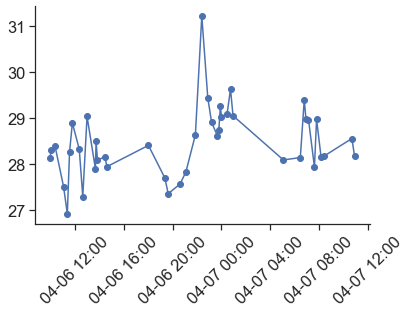

In [881]:
plt.plot(time,weights,marker='o')
plt.xticks(rotation=45)
myFmt = mdates.DateFormatter('%m-%d %H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
hlc = mdates.HourLocator(byhour=range(0,24,4))
hlc.MAXTICKS = 6000
plt.gca().xaxis.set_major_locator(hlc)   #to get a tick every 15 minutes


seaborn.despine()

In [882]:
import pykalman

In [883]:
t_ = (time[-1] -time[0])
t_ = t_.astype('timedelta64[h]')
n_hours = 1+ t_.item().total_seconds()/3600.

In [884]:
start_time

datetime.datetime(2021, 4, 6, 10, 16, 11)

In [885]:
tm

datetime.datetime(2021, 4, 7, 13, 43, 27)

In [886]:
timestep = 30 #timestep size in minutes
#start_time = time[0]
start_time = datetime.utcfromtimestamp(time[0].tolist()/1e9)
n_timesteps = int((1+n_hours)*(60/timestep))
weights_kf = np.zeros(n_timesteps) + np.nan
kf_times = [start_time]
for t_ in range(1,n_timesteps):
    tdt = start_time + timedelta(minutes=timestep*t_)
    weights_at_t = []
    for w,tm in zip(weights,time):
        tm = datetime.utcfromtimestamp(tm.tolist()/1e9)
        if abs((tm-tdt).total_seconds())<(timestep*60):
            #print(tm,tdt,(tm-tdt).total_seconds())
            weights_at_t.append(w)
            
            
    if weights_at_t:
        weights_kf[t_] = np.mean(weights_at_t)
    kf_times.append(tdt)
        

In [887]:
weights_kf_ma = np.ma.masked_invalid(weights_kf)

In [888]:
kf = pykalman.KalmanFilter(initial_state_mean=weights[0],observation_covariance=[2])

In [889]:
em_vars = ['transition_covariance',
           'initial_state_mean', 
           'observation_covariance',
           'initial_state_covariance']
kf.em(weights_kf_ma,n_iter=5,em_vars=em_vars)
a,b = kf.smooth(weights_kf_ma,)
mu = a.flatten()
std = np.sqrt(b.flatten())

In [890]:
kf.transition_covariance

array([[0.24188096]])

In [891]:
kf.observation_covariance

array([[0.13697572]])

In [892]:
weights_kf_ma.mask.sum()

16

In [893]:
kf.transition_matrices

array([[1.]])

In [894]:
len(kf_times)

52

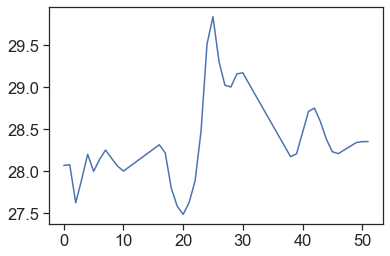

In [895]:
plt.plot(mu)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


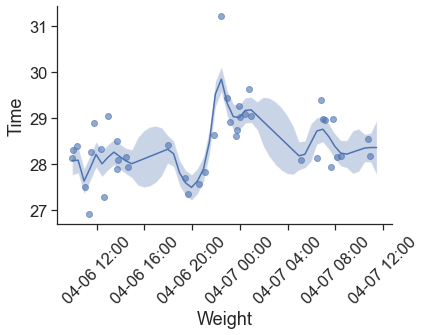

In [896]:
x_ = time
plt.plot(kf_times,a)
plt.fill_between(kf_times,mu-std,mu+std,alpha=.3)
plt.scatter(x_,weights,alpha=.6,c=clrs[0])

plt.xticks(rotation=45)
myFmt = mdates.DateFormatter('%m-%d %H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
hlc = mdates.HourLocator(byhour=range(0,24,4))
hlc.MAXTICKS = 6000
plt.gca().xaxis.set_major_locator(hlc)   #to get a tick every 15 minutes
plt.xlabel("Weight")
plt.ylabel("Time")
seaborn.despine()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


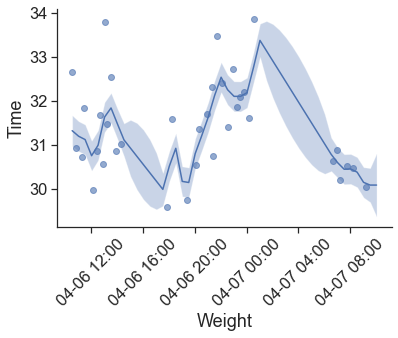

In [780]:
x_ = time
plt.plot(kf_times,a)
plt.fill_between(kf_times,mu-std,mu+std,alpha=.3)
plt.scatter(x_,weights,alpha=.6,c=clrs[0])

plt.xticks(rotation=45)
myFmt = mdates.DateFormatter('%m-%d %H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
hlc = mdates.HourLocator(byhour=range(0,24,4))
hlc.MAXTICKS = 6000
plt.gca().xaxis.set_major_locator(hlc)   #to get a tick every 15 minutes
plt.xlabel("Weight")
plt.ylabel("Time")
seaborn.despine()

In [141]:
b.flat